In [37]:
import numpy as np
from agentflow.numpy.models import Logs

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [415]:
N = 16
K = 3

In [466]:
mu = np.random.randn(2,K)
sigma = np.random.randn(2,K,K)**2 + 1e-3
eps = np.random.randn(N,K)
y = np.random.choice(2,size=N)
X = y[:,None]*(mu[1]+np.dot(eps,sigma[1]))+(1-y[:,None])*(mu[0]+np.dot(eps,sigma[0]))
w = np.random.randn(K)

In [470]:
X.shape, y.shape, w.shape

((16, 3), (16,), (3,))

In [581]:
def sigmoid(X,w):
    return 1/(1+np.exp(-np.dot(X,w)))

def nll(X,w,y):
    wTx = np.dot(X,w)
    e_wTx = np.exp(-wTx)
    logp = np.log(1+e_wTx)
    return y*logp+(1-y)*(wTx + logp)

def nll_check(X,w,y):
    p = sigmoid(X,w)
    return -(y*np.log(p)+(1-y)*np.log(1-p))

def grad_p(X,w):
    p = sigmoid(X,w)[:,None]
    return p*(1-p)*X

def grad(X,w,y):
    p = sigmoid(X,w)
    return (p-y)[:,None]*X

def grad_reverse(X,w,y):
    p = sigmoid(X,w)
    p = 1-p
    return (p-y)[:,None]*X

def gradient_checker(func,g_func,X,w,y=None):
    eps = 1e-3
    errs = []
    for i in range(len(w)):
        dw = np.zeros_like(w)
        dw[i] = eps
        if y is None:
            kwargs = {}
        else:
            kwargs = {'y':y}
        f_left = func(X,w-dw,**kwargs)
        f_right = func(X,w+dw,**kwargs)
        dfdwi = (f_right-f_left)/(2*eps)
        g = g_func(X,w,**kwargs)[:,i]
        err = np.abs(g-dfdwi).max()
        errs.append(err)
    max_abs_err = max(errs)
    if max_abs_err >= 1e-4:
        for i,err in enumerate(errs):
            print(i,err)
        raise ValueError('max_abs_err=%0.10f'%max_abs_err)
    else:
        print('max_abs_err=%0.10f'%max_abs_err)

In [474]:
gradient_checker(sigmoid,grad_p,X,w)

max_abs_err=0.0000048135


In [475]:
gradient_checker(nll,grad,X,w,y)

max_abs_err=0.0000023341


In [574]:
class Model(object):

    def learn(self,X,y,w0,T=100,lr=1,**update_kwargs):
        w = w0.copy()
        logs = Logs()
        for t in range(T):
            w = self.update(X,w,y,lr,**update_kwargs)
            loss = nll(X,w,y).mean()
            logs.append('loss',loss)
            logs.append('w',w)
        return logs

    def learn_sgd(self,X,y,w0,T=100,lr=1,batchsize=10,**update_kwargs):
        w = w0.copy()
        logs = Logs()
        idx = np.arange(len(X))
        for t in range(T):
            np.random.shuffle(idx)
            i = idx[:batchsize]
            w = self.update(X[i],w,y[i],lr,**update_kwargs)
            loss = nll(X,w,y).mean()
            logs.append('loss',loss)
            logs.append('w',w)
        return logs

class GradientDescent(Model):
    def update(self,X,w,y,lr):
        v = grad(X,w,y).mean(axis=0)
        return w - lr*v
    
class Newton(Model):
    def update(self,X,w,y,lr,alpha=1):
        p = sigmoid(X,w)[:,None]
        S = p*(1-p)
        H = np.dot(X.T,S*X) + alpha*np.eye(len(w))
        H_inv = np.linalg.inv(H)
        g = grad(X,w,y).sum(axis=0)
        v = np.dot(H_inv,g)
        return w - lr*v

class LearnedUpdate(Model):
    def update(self,X,w,y,lr,alpha=1):
        dpdw = grad_p(X,w)
        p = sigmoid(X,w)
        err = p-y
        H = np.dot(dpdw.T,dpdw) + alpha*np.eye(len(w))
        H_inv = np.linalg.inv(H)
        g = np.dot(err,dpdw)
        v = np.dot(H_inv,g)
        return w - lr*v
    
    
class LearnedUpdate2(Model):
    def update(self,X,w,y,lr,alpha=1):
        dpdw = grad_p(X,w)
        p = sigmoid(X,w)
        S = p*(1-p)
        err = p-y
        g = np.dot(X.T,err*S)
        H = np.dot(X.T,S[:,None]*X) + alpha*np.eye(len(w))
        H_inv = np.linalg.inv(H)
        v = np.dot(H_inv,g)
        return w - lr*v
    
    

In [583]:
Newton().update(X,w,y,lr=1)

array([ 2.82732531,  2.02440399, -1.23176783])

In [575]:
w0 = np.random.randn(K)

In [578]:
T = 40

#w0 = np.random.randn(K)

inputs = {
    'X': X,
    'y': y,
    'w0': w0,
    'T': T,
}

logs = {
    'gradient_descent': GradientDescent().learn(
        lr=5e-1,**inputs),
    'newton': Newton().learn(
        lr=5e-1,alpha=1e-3,**inputs),
    'learned_update': LearnedUpdate().learn(
        lr=5e-1,alpha=1e-3,**inputs),
    'learned_update2': LearnedUpdate2().learn(
        lr=1,alpha=1e-3,**inputs),
}

(-0.7, -0.5)

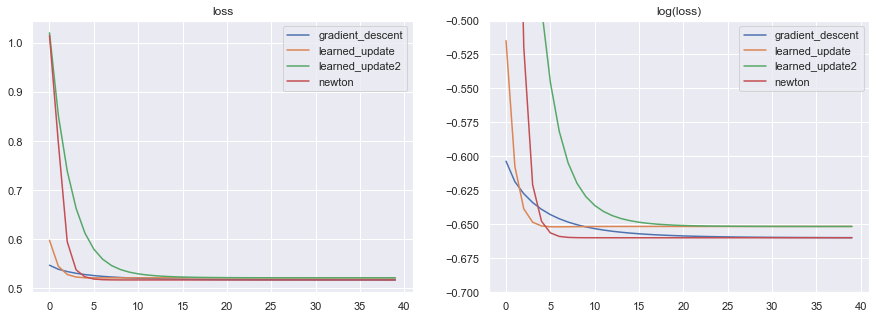

In [580]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for k in sorted(logs):
    plt.plot(logs[k].stack('loss'),label=k)
plt.legend()
plt.title('loss')

plt.subplot(1,2,2)
for k in sorted(logs):
    plt.plot(np.log(logs[k].stack('loss')),label=k)
plt.legend()
plt.title('log(loss)')
plt.ylim(-0.7,-0.5)

In [528]:
T = 100

inputs = {
    'X': X,
    'y': y,
    'w0': w0,
    'T': T,
}

logs_sgd = {
    'gradient_descent': GradientDescent().learn_sgd(
        lr=2e-1,**inputs),
    'newton': Newton().learn_sgd(
        lr=1e-1,alpha=1e-3,**inputs),
    'learned_update': LearnedUpdate().learn_sgd(
        lr=1e-1,alpha=1e-3,**inputs),
}

Text(0.5, 1.0, 'log(loss)')

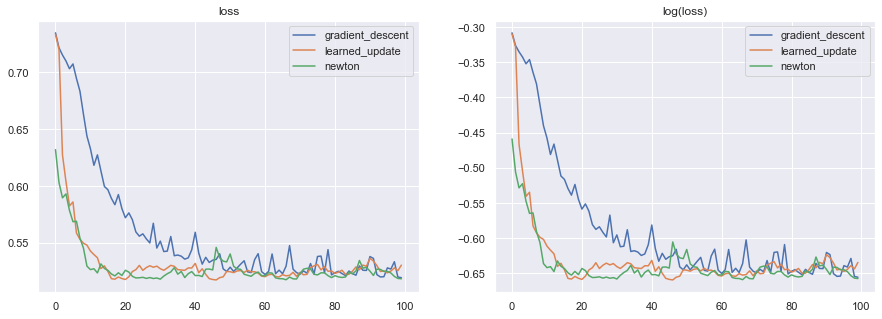

In [529]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for k in sorted(logs_sgd):
    plt.plot(logs_sgd[k].stack('loss'),label=k)
plt.legend()
plt.title('loss')

plt.subplot(1,2,2)
for k in sorted(logs_sgd):
    plt.plot(np.log(logs_sgd[k].stack('loss')),label=k)
plt.legend()
plt.title('log(loss)')

## Multiple runs

In [567]:
S = 64

sample_logs_sgd = []
for s in range(S):
    T = 100
    inputs = {
        'X': X,
        'y': y,
        'w0': np.random.randn(K),
        'T': T,
    }
    logs_sgd = {
        'gradient_descent': GradientDescent().learn_sgd(
            lr=4e-1,**inputs),
        'newton': Newton().learn_sgd(
            lr=3e-2,alpha=1e-3,**inputs),
        'learned_update': LearnedUpdate().learn_sgd(
            lr=1e-1,alpha=1e-3,**inputs),
    }
    sample_logs_sgd.append(logs_sgd)

In [568]:
def plot_percentiles(x,label=None):
    mean = x.mean(axis=0)
    p10 = np.percentile(x,5,axis=0)
    p90 = np.percentile(x,95,axis=0)
    [a] = plt.plot(mean,alpha=0.7,label=label)
    plt.fill_between(range(len(p10)),p10,p90,color=a.get_color(),alpha=0.2)

(-0.75, 0)

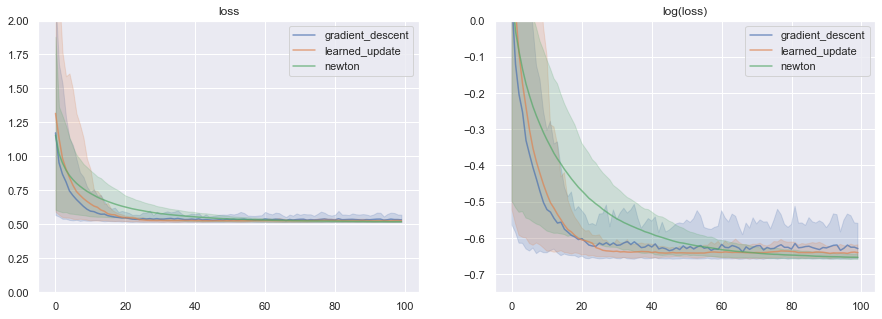

In [569]:
plt.figure(figsize=(15,5))

losses = {
    k: np.stack([l[k].stack('loss') for l in sample_logs_sgd])
    for k in sorted(sample_logs_sgd[0])
}
plt.subplot(1,2,1)
for k in sorted(losses):
    plot_percentiles(losses[k],label=k)
plt.legend()
plt.title('loss')
plt.ylim(0,2)

plt.subplot(1,2,2)
for k in sorted(logs_sgd):
    plot_percentiles(np.log(losses[k]),label=k)
plt.legend()
plt.title('log(loss)')
plt.ylim(-0.75,0)
